In [1]:
# Import required libraries
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F

import torchvision
import numpy as np
import torchvision.transforms as transforms
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score


/Users/sinanozdemir/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
# standardize random numbers for reproducibility
torch.manual_seed(0)


In [3]:
img = torchvision.datasets.MNIST(root='../data', train=True, download=True)[0]

In [4]:
img # PIL == Pillow

(<PIL.Image.Image image mode=L size=28x28>, 5)

In [11]:
# Load MNIST dataset
batch_size = 4
transform = transforms.Compose(
    [
     transforms.ToTensor(),   # convert to pytorch tensor
     transforms.Normalize((0.1307,), (0.3081,)),  # standardize the values with mean + std. Found before running code
    # transforms.RandomVerticalFlip()
    ]  
)

train_dataset = torchvision.datasets.MNIST(root='../data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='../data', train=False, transform=transform, download=True)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


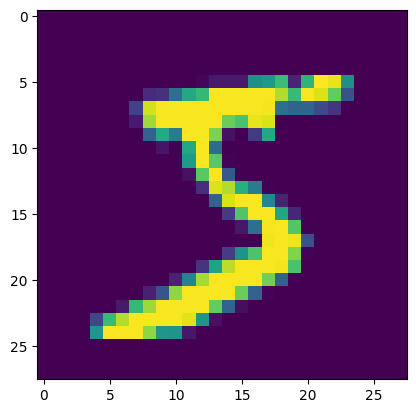

In [12]:
# transpose the array to (28, 28) format expected by Matplotlib
array = np.squeeze(np.transpose(train_dataset[0][0], (1, 2, 0)))

# plot the image using Matplotlib
plt.imshow(array)
plt.show()

In [13]:
next(iter(test_loader))[0].shape

torch.Size([4, 1, 28, 28])

In [19]:
# Define the neural network model
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):  # e.g. input_size=10, hidden_size=4, num_classes=2
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size) # 1x10 input vector X 10x4 = 1x4
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)  # 1x4 X 4x2 = 1x2
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

In [20]:
model = NeuralNet(10, 4, 2)
model

NeuralNet(
  (fc1): Linear(in_features=10, out_features=4, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=4, out_features=2, bias=True)
)

In [21]:
model.fc1.weight

Parameter containing:
tensor([[-0.0739,  0.2764,  0.1351, -0.0710,  0.2280, -0.1024, -0.0900, -0.2366,
          0.0865, -0.0857],
        [-0.0362, -0.1428,  0.2449,  0.2848,  0.0893, -0.0039,  0.0934, -0.2021,
         -0.1032, -0.2837],
        [ 0.0041, -0.2331, -0.0379,  0.1163,  0.2575, -0.0439, -0.0282,  0.1182,
         -0.2265, -0.2375],
        [ 0.2978, -0.1054, -0.2157,  0.2318,  0.1340,  0.1477,  0.1085,  0.2582,
          0.2479, -0.1721]], requires_grad=True)

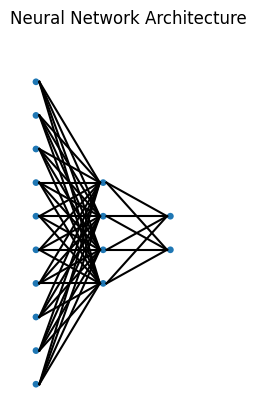

In [22]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def visualize_neural_network(input_size, hidden_size, num_classes):
    fig, ax = plt.subplots()

    # Define the layers
    layers = [input_size, hidden_size, num_classes]
    layer_positions = [(0, i) for i in range(len(layers))]

    # Draw the layers
    for i, (x, layer) in enumerate(zip(layer_positions, layers)):
        for j in range(layer):
            circle = patches.Circle((i * 2, j - layer / 2), radius=0.1, fill=True)
            ax.add_patch(circle)

            # Draw connections to the next layer
            if i < len(layers) - 1:
                for k in range(layers[i + 1]):
                    line = plt.Line2D([i * 2 + 0.1, (i + 1) * 2 - 0.1], [j - layer / 2, k - layers[i + 1] / 2], color="black")
                    ax.add_line(line)

    ax.set_xlim(-0.5, len(layers) * 2)
    ax.set_ylim(-max(layers) / 2 - 0.5, max(layers) / 2 + 0.5)
    ax.set_aspect('equal')
    plt.axis('off')
    plt.title('Neural Network Architecture')
    plt.show()

# Example parameters
input_size = 10
hidden_size = 4
num_classes = 2

# Visualize the neural network
visualize_neural_network(input_size, hidden_size, num_classes)


In [23]:
# Some loss function options
cross_entropy_loss = nn.CrossEntropyLoss()
nll_loss = nn.NLLLoss()
mse_loss = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [24]:
# input layer, a single hidden layer, and an output layer
# Define hyperparameters
input_size = 784  # 28x28 pixels
hidden_size = 128
num_classes = 10

batch_size = 100

In [25]:
# Function to train the model
def train_model(model, loss_function, train_loader, optimizer, num_epochs=10):
    # Put the model in training mode
    model.train()
    
    # Iterate over the number of epochs
    for epoch in range(num_epochs):
        # Initialize the running loss for this epoch to zero
        running_loss = 0.0
        
        # Iterate over each batch in the training loader
        for i, (images, labels) in enumerate(train_loader):
            
            # Reshape the images tensor to have size (batch_size, input_size)
            images = images.reshape(-1, input_size)
            # Forward pass: compute the outputs of the model given the input images
            outputs = model(images)
            # Compute the loss between the outputs and the true labels
            loss = loss_function(outputs, labels)
            # Backward pass: compute the gradients of the loss with respect to the model parameters
            optimizer.zero_grad()
            loss.backward()
            # Update the model parameters using the optimizer
            optimizer.step()
            
            # Add the current batch loss to the running loss for this epoch
            running_loss += loss.item()

        # Compute the average loss over all batches for this epoch and print it
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')


In [26]:
# Function to evaluate the model
def evaluate_model(model, test_loader):
    # Put the model in evaluation mode
    model.eval()
    
    # Initialize empty lists to store true and predicted labels
    y_true, y_pred = [], []
    
    # Disable gradient computation since we're only evaluating the model
    with torch.no_grad():
        # Iterate over each batch in the test loader
        for images, labels in test_loader:
            # Reshape the images tensor to have size (batch_size, input_size)
            images = images.reshape(-1, input_size)
            
            # Forward pass: compute the outputs of the model given the input images
            outputs = model(images)
            
            # Find the predicted class for each image in the batch
            _, predicted = torch.max(outputs.data, 1)
            
            # Append the true and predicted labels for this batch to the lists
            y_true.extend(labels.numpy())
            y_pred.extend(predicted.numpy())
    
    # Calculate evaluation metrics using the true and predicted labels
    accuracy, f1, precision, recall = evaluate_model_metrics(np.array(y_true), np.array(y_pred))
    
    # Return the evaluation metrics
    return accuracy, f1, precision, recall

# Function to calculate evaluation metrics
def evaluate_model_metrics(y_true, y_pred):
    # Compute the accuracy, F1 score, precision, and recall
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')

    # Return the evaluation metrics
    return accuracy, f1, precision, recall

# Define a dictionary of loss functions
loss_functions = {
    'CrossEntropyLoss': nn.CrossEntropyLoss(),
    'NLLLoss': nn.NLLLoss(),  # requires logsoftmax output (according to docs, so loss will be wrong without it!)
    'MultiMarginLoss': nn.MultiMarginLoss(),
    'KLDivLoss': nn.KLDivLoss()   # requires logsoftmax output (according to docs, so loss will be wrong without it!)
}

In [27]:
input_size

784

In [28]:
# Train and evaluate the model using different loss functions
for loss_name, loss_function in loss_functions.items():
    print(f'Training with {loss_name}:')
    
    # Initialize a new model and optimizer for each loss function
    model = NeuralNet(input_size, hidden_size, num_classes)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    # Train the model
    train_model(model, loss_function, train_loader, optimizer, num_epochs=5)

    # Evaluate the model
    accuracy, f1, precision, recall = evaluate_model(model, test_loader)
    print(f'Performance metrics for {loss_name}:')
    print(f'Accuracy: {accuracy:.4f}, F1-score: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}\n')


Training with CrossEntropyLoss:
Epoch [1/5], Loss: 0.2136
Epoch [2/5], Loss: 0.1270
Epoch [3/5], Loss: 0.1065
Epoch [4/5], Loss: 0.0933
Epoch [5/5], Loss: 0.0838
Performance metrics for CrossEntropyLoss:
Accuracy: 0.9660, F1-score: 0.9658, Precision: 0.9658, Recall: 0.9660

Training with NLLLoss:
Epoch [1/5], Loss: -2126505.9544
Epoch [2/5], Loss: -12709581.0619
Epoch [3/5], Loss: -32173597.2684
Epoch [4/5], Loss: -60374686.1815
Epoch [5/5], Loss: -97212378.5904


/Users/sinanozdemir/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Performance metrics for NLLLoss:
Accuracy: 0.1135, F1-score: 0.0204, Precision: 0.0114, Recall: 0.1000

Training with MultiMarginLoss:
Epoch [1/5], Loss: 0.0352
Epoch [2/5], Loss: 0.0196
Epoch [3/5], Loss: 0.0162
Epoch [4/5], Loss: 0.0143
Epoch [5/5], Loss: 0.0126
Performance metrics for MultiMarginLoss:
Accuracy: 0.9651, F1-score: 0.9649, Precision: 0.9655, Recall: 0.9646

Training with KLDivLoss:


/Users/sinanozdemir/Library/Python/3.9/lib/python/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


RuntimeError: kl_div: Integral inputs not supported.

In [ ]:
# UH OH, KL didn't even run :(

# Making our code with with KL and NLL

In [29]:
def one_hot_encode(labels, num_classes):
    # Create a tensor of zeros with shape [len(labels), num_classes]
    one_hot = torch.zeros(len(labels), num_classes)
    
    # Use scatter_ to assign 1s to the correct class indices
    one_hot.scatter_(1, labels.unsqueeze(1), 1)
    
    return one_hot


In [30]:
# Function to train the model
def train_model(model, loss_function, train_loader, optimizer, num_epochs=10):
    # Put the model in training mode
    model.train()
    
    # Iterate over the number of epochs
    for epoch in range(num_epochs):
        # Initialize the running loss for this epoch to zero
        running_loss = 0.0
        
        # Iterate over each batch in the training loader
        for i, (images, labels) in enumerate(train_loader):
            
            # Reshape the images tensor to have size (batch_size, input_size)
            images = images.reshape(-1, input_size)
            # Forward pass: compute the outputs of the model given the input images
            outputs = model(images)

            #### NEW ####
            if 'KL' in str(loss_function) or 'NLL' in str(loss_function):
                outputs = F.log_softmax(outputs, dim=1)
            if 'KL' in str(loss_function):  # KL also need one hot 
                labels = one_hot_encode(labels, 10)
            #### NEW ####
            
            # Compute the loss between the outputs and the true labels
            loss = loss_function(outputs, labels)
            # Backward pass: compute the gradients of the loss with respect to the model parameters
            optimizer.zero_grad()
            loss.backward()
            # Update the model parameters using the optimizer
            optimizer.step()
            
            # Add the current batch loss to the running loss for this epoch
            running_loss += loss.item()

        # Compute the average loss over all batches for this epoch and print it
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')


In [31]:
# Define a dictionary of loss functions
loss_functions = {

    'NLLLoss': nn.NLLLoss(),  
    'KLDivLoss': nn.KLDivLoss(reduction='batchmean'),  # to avoid deprecation warning, I'm setting reduction to batchmean
    'CrossEntropyLoss': nn.CrossEntropyLoss()
}
# Train and evaluate the model using different loss functions
for loss_name, loss_function in loss_functions.items():
    print(f'Training with {loss_name}:')
    
    # Initialize a new model and optimizer for each loss function
    model = NeuralNet(input_size, hidden_size, num_classes)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    # Train the model
    train_model(model, loss_function, train_loader, optimizer, num_epochs=5)

    # Evaluate the model
    accuracy, f1, precision, recall = evaluate_model(model, test_loader)
    print(f'Performance metrics for {loss_name}:')
    print(f'Accuracy: {accuracy:.4f}, F1-score: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}\n')


Training with NLLLoss:
Epoch [1/5], Loss: 0.2162
Epoch [2/5], Loss: 0.1299
Epoch [3/5], Loss: 0.1059
Epoch [4/5], Loss: 0.0941
Epoch [5/5], Loss: 0.0850
Performance metrics for NLLLoss:
Accuracy: 0.9651, F1-score: 0.9648, Precision: 0.9647, Recall: 0.9652

Training with KLDivLoss:
Epoch [1/5], Loss: 0.2166
Epoch [2/5], Loss: 0.1232
Epoch [3/5], Loss: 0.1046
Epoch [4/5], Loss: 0.0937
Epoch [5/5], Loss: 0.0842
Performance metrics for KLDivLoss:
Accuracy: 0.9669, F1-score: 0.9667, Precision: 0.9669, Recall: 0.9669

Training with CrossEntropyLoss:
Epoch [1/5], Loss: 0.2161
Epoch [2/5], Loss: 0.1275
Epoch [3/5], Loss: 0.1057
Epoch [4/5], Loss: 0.0941
Epoch [5/5], Loss: 0.0878
Performance metrics for CrossEntropyLoss:
Accuracy: 0.9678, F1-score: 0.9675, Precision: 0.9682, Recall: 0.9672



/Users/sinanozdemir/Library/Python/3.9/lib/python/site-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


<Axes: >

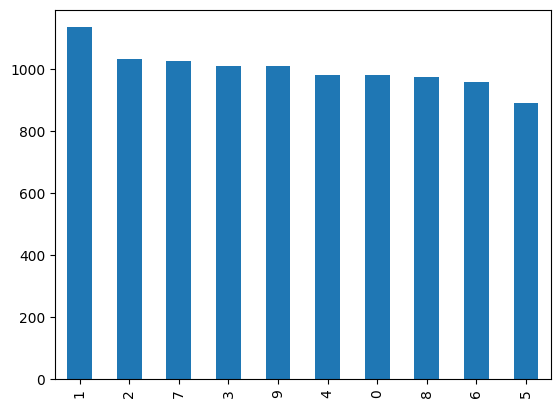

In [32]:
import pandas as pd

# KL is better for imbalanced data, which this isn't so much
pd.Series(test_dataset.train_labels).value_counts().plot(kind='bar')

In [33]:
test_dataset

Dataset MNIST
    Number of datapoints: 10000
    Root location: ../data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )

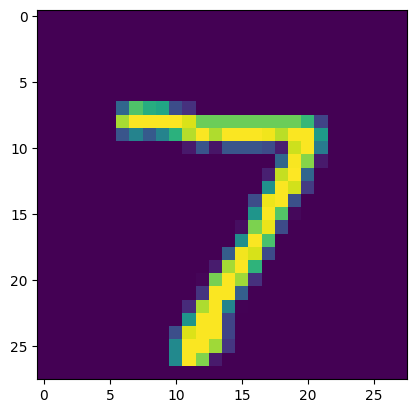

In [34]:
# transpose the array to (28, 28) format expected by Matplotlib
array = np.squeeze(np.transpose(test_dataset[0][0], (1, 2, 0)))

# plot the image using Matplotlib
plt.imshow(array)
plt.show()

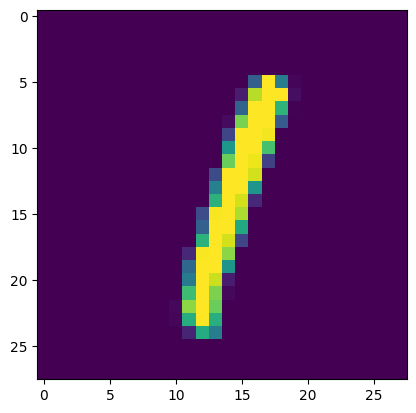

In [35]:
# transpose the array to (28, 28) format expected by Matplotlib
array = np.squeeze(np.transpose(test_dataset[5][0], (1, 2, 0)))

# plot the image using Matplotlib
plt.imshow(array)
plt.show()

In [36]:
# MSE loss of image to itself compares pixel values (perfect match for the same image)
mse_loss(test_dataset[0][0], test_dataset[0][0])

tensor(0.)

In [37]:
# MSE loss of image to itself compares pixel values (not a perfect match for different images)
# keep this in mind for diffusion
mse_loss(test_dataset[0][0], test_dataset[5][0])

tensor(1.0462)